# Linear Regression variants, KNN and Random Forest tested on Cardano 

In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import seaborn as sns

In [32]:
cardano=pd.read_excel(r'/Users/radhikagarg/Desktop/TP TERM 3/TP/data/Cardano.xlsx',sheet_name="cardano")
print(cardano.tail())

           Date     Price      Open      High       Low          Vol.  \
1156 2021-03-02  1.224643  1.296248  1.298971  1.182334  1.100000e+09   
1157 2021-03-03  1.214324  1.224523  1.265522  1.209046  7.070200e+08   
1158 2021-03-04  1.112490  1.214405  1.229926  1.068434  1.100000e+09   
1159 2021-03-05  1.158227  1.112463  1.195702  1.037863  1.310000e+09   
1160 2021-03-06  1.129016  1.158277  1.181553  1.086688  7.570800e+08   

      Change %       MktCap  Tradecount  
1156   -0.0552  39155277835      993914  
1157   -0.0084  38868096418      529175  
1158   -0.0839  35618147966      882082  
1159    0.0411  37332335359     1132387  
1160   -0.0252  36133913814      671557  


# EDA CARDANO

<AxesSubplot:title={'center':'CARDANO PRICES'}, ylabel='Price'>

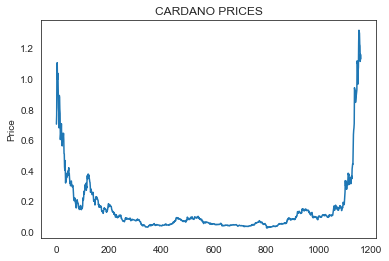

In [33]:
plt.title("CARDANO PRICES")
sns.lineplot(data=cardano['Price'])

<AxesSubplot:>

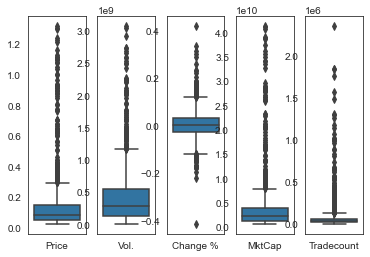

In [34]:
fig, axs = plt.subplots(ncols=5)
sns.set_style("whitegrid")
sns.boxplot(data=cardano[['Price']],ax=axs[0])
sns.boxplot(data=cardano[['Vol.']],ax=axs[1])
sns.boxplot(data=cardano[['Change %']],ax=axs[2])
sns.boxplot(data=cardano[['MktCap']],ax=axs[3])
sns.boxplot(data=cardano[['Tradecount']],ax=axs[4])

<AxesSubplot:>

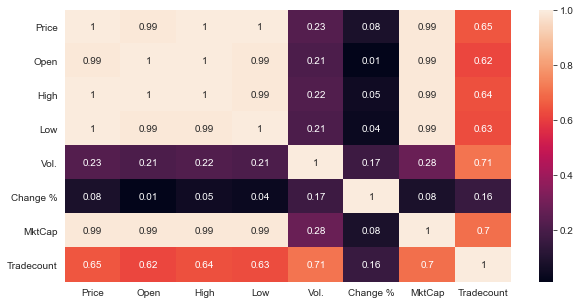

In [35]:
plt.figure(figsize=(10,5))
sns.heatmap(cardano.corr().round(2), annot=True)

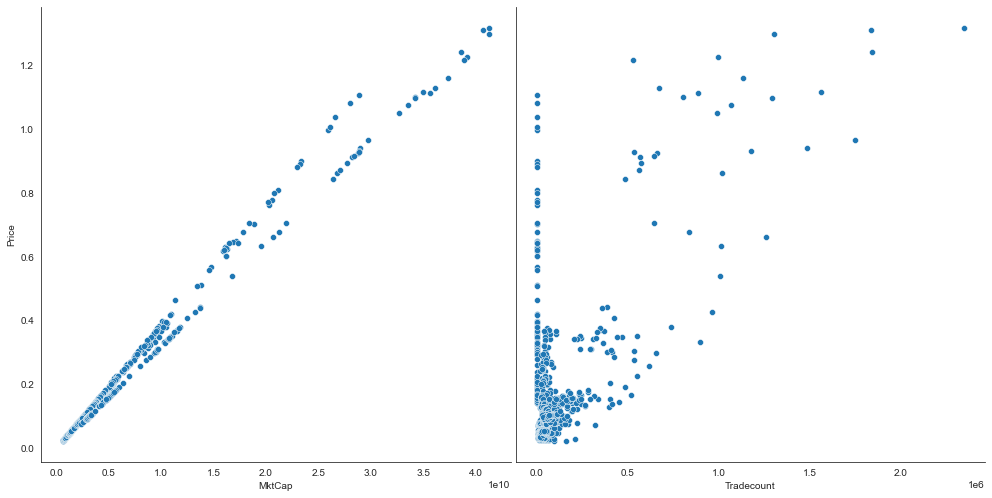

In [36]:
sns.set_style("white")
sns.pairplot(cardano,x_vars=['MktCap','Tradecount'],y_vars='Price',height=7,kind='scatter',diag_kind=None)

In [37]:
import scipy as scipy
from scipy.stats.mstats import normaltest
print(normaltest(cardano['Price']))

NormaltestResult(statistic=851.1558083778355, pvalue=1.4923290419708248e-185)


In [38]:
from scipy.stats import boxcox

def boxcox_transformation(a):
    boxcox_res=boxcox(a)
    print(boxcox_res)
    boxcox_y=boxcox_res[0] # as it has two outputs one the ransformed array and the lambda used to transform
    return boxcox_y
    
boxcox_cardano_price=boxcox_transformation(cardano.Price)

print(normaltest(boxcox_cardano_price))

(array([-0.38666555, -0.29111931,  0.07550091, ...,  0.10381306,
        0.1416323 ,  0.11774298]), -0.4993736764516259)
NormaltestResult(statistic=109.01534725572931, pvalue=2.1262685819423504e-24)


# LINEAR REGRESSION

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics

#x1=pd.DataFrame(boxcox_cardano_mktcap.reshape(-1,1))
#x2=pd.DataFrame(boxcox_cardano_trade.reshape(-1,1))
#x=pd.concat([x1, x2], axis=1)
#x.columns=['mktvalue','tradecount']
x=cardano[['MktCap','Tradecount']]
y=boxcox_cardano_price

lr=LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,  random_state=101)
model=lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print("INTERCEPT", model.intercept_,"\n")
print("COEFS", model.coef_,"\n")
print("R_SQUARED", model.score(x,y),"\n")

mse=cross_val_score(lr,x,y,scoring='neg_mean_squared_error',cv=5) # want cv to find out mean squared err
mean_mse=np.mean(mse)
print("\nMean Negative square from CV=5")
print(mean_mse)

Mean Absolute Error: 1.5177718593695158
Mean Squared Error: 3.07875921581214
Root Mean Squared Error: 1.7546393406658076
INTERCEPT -6.373197062413037 

COEFS [ 3.70518006e-10 -2.60241378e-06] 

R_SQUARED 0.523026176512373 


Mean Negative square from CV=5
-13.86248671124846


            0
344  0.158664
345  0.108070
346  0.130619
347  0.177335
348  0.043197
            0
344  0.085233
345  0.075514
346  0.077645
347  0.083174
348  0.061941


Text(0.5, 1.0, 'Linear Regression')

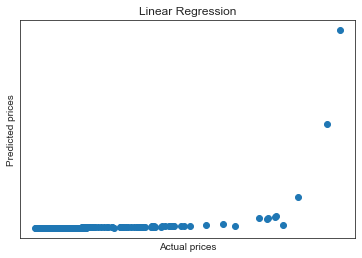

In [40]:
from scipy.special import inv_boxcox
price_test=inv_boxcox(y_test,-0.4993736764516259)
price_pred=inv_boxcox(y_pred,-0.4993736764516259)

y_pred_data = pd.DataFrame(price_pred)
y_test_data = pd.DataFrame(price_test)
print(y_test_data.tail())
print(y_pred_data.tail())

plt.scatter(y_test_data,y_pred_data)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.xticks([])
plt.yticks([])
plt.title("Linear Regression")

# HUBBER REGRESSION

In [15]:
#HuberRegressor model;Huber loss is a loss function used in robust regression that is less sensitive to outliers 
#in data than the squared error loss. The Hubber Regressor provided by scikit-learn optimizes the squared loss and
#absolute loss for the samples based on epsilon, where epsilon is a parameter to control the number of samples 
#which should be treated as outliers.

from sklearn.linear_model import HuberRegressor
x=cardano[['MktCap','Tradecount']]
y=boxcox_cardano_price

hr=HuberRegressor(alpha=0.001, epsilon=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,  random_state=101)
model=hr.fit(x_train,y_train)
y_pred = hr.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print("INTERCEPT", model.intercept_,"\n")
print("COEFS", model.coef_,"\n")
print("R_SQUARED", model.score(x,y),"\n")

mse=cross_val_score(lr,x,y,scoring='neg_mean_squared_error',cv=5) # want cv to find out mean squared err
print("\nMean Negative square from CV=5")
mean_mse=np.mean(mse)
print(mean_mse)

Mean Absolute Error: 4.771466203156767
Mean Squared Error: 30.035744944780173
Root Mean Squared Error: 5.480487655745625
INTERCEPT -3.0012739648609474e-18 

COEFS [-3.05986468e-10 -2.62494572e-14] 

R_SQUARED -3.8781736574081513 


Mean Negative square from CV=5
-13.86248671124847


            0
344  0.158664
345  0.108070
346  0.130619
347  0.177335
348  0.043197
            0
344  0.324119
345  0.435907
346  0.431326
347  0.293806
348  0.728137


Text(0.5, 1.0, 'Hubber Regression')

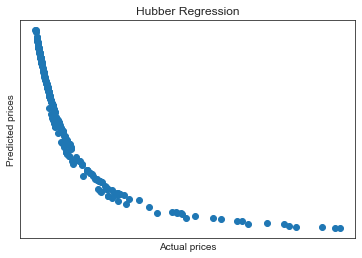

In [16]:
from scipy.special import inv_boxcox
price_test=inv_boxcox(y_test,-0.4993736764516259)
price_pred=inv_boxcox(y_pred,-0.4993736764516259)

y_pred_data = pd.DataFrame(price_pred)
y_test_data = pd.DataFrame(price_test)
print(y_test_data.tail())
print(y_pred_data.tail())

plt.scatter(y_test_data,y_pred_data)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.xticks([])
plt.yticks([])
plt.title("Hubber Regression")

# POLYNOMIAL REGRESSION

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

x=cardano[['MktCap','Tradecount']]
y=boxcox_cardano_price


# TRAINING ERROR PER DEGREE
train_rmse_errors = [] #Saving root mean square for the train set
# TEST ERROR PER DEGREE
test_rmse_errors = [] #Saving root mean square for the test set

for d in range(1,10): #Choose any range you want, the larger the range you test, the more degrees you take into account.
    
    # CREATE POLY DATA SET FOR DEGREE "d"
    polynomial_converter = PolynomialFeatures(degree=d,include_bias=False) #d is from 1 to 10, we don't want array of 1 as features.
    poly_features = polynomial_converter.fit_transform(x)
    
    # SPLIT THIS NEW POLY DATA SET
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)
    
    # TRAIN ON THIS NEW POLY SET
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train,y_train)
    
    # PREDICT ON BOTH TRAIN AND TEST
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate Errors
    
    # Errors on Train Set
    train_RMSE = np.sqrt(mean_squared_error(y_train,train_pred)) #Notice we have y train here
    
    # Errors on Test Set
    test_RMSE = np.sqrt(mean_squared_error(y_test,test_pred)) #Notice we have y test here

    # Append errors to lists for plotting later
    
   
    train_rmse_errors.append(train_RMSE)
    test_rmse_errors.append(test_RMSE)

In [42]:
train_rmse_errors

[1.7122589636749994,
 1.135558418625346,
 1.8515011554255583,
 2.1276390927823217,
 2.2215602051602836,
 2.264643598430088,
 2.291056076165375,
 2.3107317080376824,
 2.3271783388987317]

In [43]:
test_rmse_errors

[1.7546393406658076,
 1.182058117003593,
 1.932651640587429,
 2.2285517102678187,
 2.3370177418576543,
 2.39342776240107,
 2.440100426696346,
 2.4861614878255747,
 2.6412496097309646]

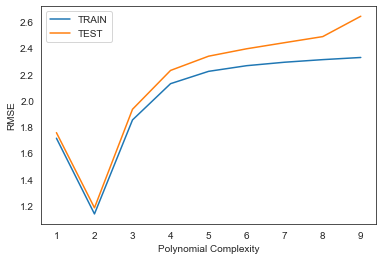

In [44]:
plt.plot(range(1,10),train_rmse_errors[:9],label='TRAIN')
plt.plot(range(1,10),test_rmse_errors[:9],label='TEST')
plt.xlabel("Polynomial Complexity")
plt.ylabel("RMSE")
plt.legend()

# no need of polynomial regression as dregree 1 is optimal as seen in graph

In [45]:
x=cardano[['MktCap','Tradecount']]
y=boxcox_cardano_price


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,  random_state=101)
polynomial_converter = PolynomialFeatures(degree=2,include_bias=False) #d is from 1 to 10, we don't want array of 1 as features.
poly_features = polynomial_converter.fit_transform(x)
model=LinearRegression(fit_intercept=True)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print("INTERCEPT", model.intercept_,"\n")
print("COEFS", model.coef_,"\n")
print("R_SQUARED", model.score(x,y),"\n")

mse=cross_val_score(lr,x,y,scoring='neg_mean_squared_error',cv=5) # want cv to find out mean squared err
print("\nMean Negative square from CV=5")
mean_mse=np.mean(mse)
print(mean_mse)

Mean Absolute Error: 1.5177718593695158
Mean Squared Error: 3.07875921581214
Root Mean Squared Error: 1.7546393406658076
INTERCEPT -6.373197062413037 

COEFS [ 3.70518006e-10 -2.60241378e-06] 

R_SQUARED 0.523026176512373 


Mean Negative square from CV=5
-13.86248671124846


            0
344  0.158664
345  0.108070
346  0.130619
347  0.177335
348  0.043197
            0
344  0.085233
345  0.075514
346  0.077645
347  0.083174
348  0.061941


Text(0.5, 1.0, 'Polynomial Regression')

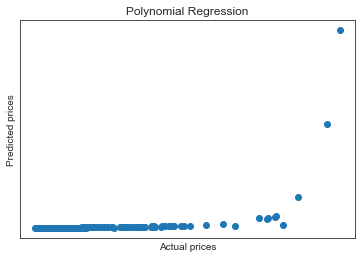

In [22]:
from scipy.special import inv_boxcox
price_test=inv_boxcox(y_test,-0.4993736764516259)
price_pred=inv_boxcox(y_pred,-0.4993736764516259)

y_pred_data = pd.DataFrame(price_pred)
y_test_data = pd.DataFrame(price_test)
print(y_test_data.tail())
print(y_pred_data.tail())

plt.scatter(y_test_data,y_pred_data)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.xticks([])
plt.yticks([])
plt.title("Polynomial Regression")

# ELASTICNET

In [46]:
from sklearn.linear_model import ElasticNetCV

x=cardano[['MktCap','Tradecount']]
y=boxcox_cardano_price

lr= ElasticNetCV(l1_ratio=0.5)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,  random_state=101)
model=lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print("INTERCEPT", model.intercept_,"\n")
print("COEFS", model.coef_,"\n")
print("R_SQUARED", model.score(x,y),"\n")

mse=cross_val_score(lr,x,y,scoring='neg_mean_squared_error',cv=5) # want cv to find out mean squared err
print("\nMean Negative square from CV=5")
mean_mse=np.mean(mse)
print(mean_mse)

Mean Absolute Error: 1.5436671454204598
Mean Squared Error: 3.2618614571358644
Root Mean Squared Error: 1.8060624178404976
INTERCEPT -6.335471111892373 

COEFS [ 3.05860327e-10 -0.00000000e+00] 

R_SQUARED 0.5020763207412813 


Mean Negative square from CV=5
-5.411136348707212


            0
344  0.158664
345  0.108070
346  0.130619
347  0.177335
348  0.043197
            0
344  0.085794
345  0.074811
346  0.075141
347  0.090417
348  0.062528


Text(0.5, 1.0, 'ElasticNet Regression')

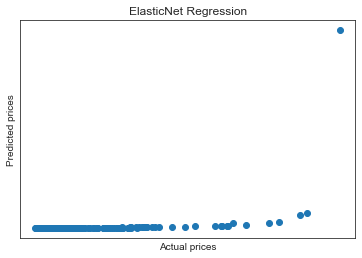

In [47]:
from scipy.special import inv_boxcox
price_test=inv_boxcox(y_test,-0.4993736764516259)
price_pred=inv_boxcox(y_pred,-0.4993736764516259)

y_pred_data = pd.DataFrame(price_pred)
y_test_data = pd.DataFrame(price_test)
print(y_test_data.tail())
print(y_pred_data.tail())

plt.scatter(y_test_data,y_pred_data)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.xticks([])
plt.yticks([])
plt.title("Hubber Regression")
plt.title("ElasticNet Regression")

# KNN

In [48]:
# Grid Search for Parameter Tuning 
from sklearn.neighbors import KNeighborsRegressor 


x=cardano[['MktCap','Tradecount']]
y=boxcox_cardano_price


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,  random_state=101)
model = KNeighborsRegressor(n_neighbors=10)
knn = model.fit(x_train, y_train)
y_pred = knn.predict(x_test)

print('\nMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print("R_SQUARED", model.score(x,y),"\n")

mse=cross_val_score(knn,x,y,scoring='neg_mean_squared_error',cv=5) # want cv to find out mean squared err
print("\nMean Negative square from CV=5")
mean_mse=np.mean(mse)
print(mean_mse)


Mean Absolute Error: 0.08084129944800683
Mean Squared Error: 0.021199570049691082
Root Mean Squared Error: 0.14560072132270183
R_SQUARED 0.9974043932063468 


Mean Negative square from CV=5
-0.059555865177982815


            0
344  0.158664
345  0.108070
346  0.130619
347  0.177335
348  0.043197
            0
344  0.169324
345  0.120368
346  0.117292
347  0.196025
348  0.043083


Text(0.5, 1.0, 'KNN Regression')

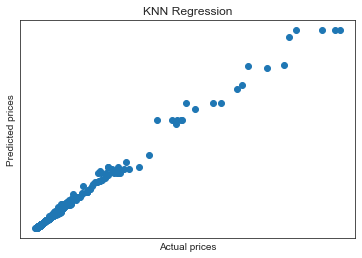

In [49]:
from scipy.special import inv_boxcox
price_test=inv_boxcox(y_test,-0.4993736764516259)
price_pred=inv_boxcox(y_pred,-0.4993736764516259)

y_pred_data = pd.DataFrame(price_pred)
y_test_data = pd.DataFrame(price_test)
print(y_test_data.tail())
print(y_pred_data.tail())

plt.scatter(y_test_data,y_pred_data)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.xticks([])
plt.yticks([])
plt.title("Hubber Regression")
plt.title("KNN Regression")

# RANDOM FOREST

In [50]:
from sklearn.ensemble import RandomForestRegressor

x=cardano[['MktCap','Tradecount']]
y=boxcox_cardano_price

# Model for best neighbour
model = RandomForestRegressor()#n_estimators=100,max_depth=4, random_state=17)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,  random_state=101)
rf = model.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print('\nMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print("R_SQUARED", model.score(x,y),"\n")

mse=cross_val_score(knn,x,y,scoring='neg_mean_squared_error',cv=5) # want cv to find out mean squared err
print("\nMean Negative square from CV=5")
mean_mse=np.mean(mse)
print(mean_mse)


Mean Absolute Error: 0.0581489381879129
Mean Squared Error: 0.013258789886146708
Root Mean Squared Error: 0.11514681882773274
R_SQUARED 0.9991509272103978 


Mean Negative square from CV=5
-0.059555865177982815


            0
344  0.158664
345  0.108070
346  0.130619
347  0.177335
348  0.043197
            0
344  0.160826
345  0.112974
346  0.125833
347  0.181477
348  0.042846


Text(0.5, 1.0, 'RandomForest Regression')

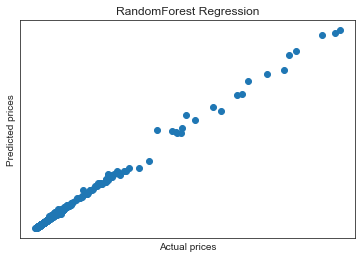

In [30]:
from scipy.special import inv_boxcox
price_test=inv_boxcox(y_test,-0.4993736764516259)
price_pred=inv_boxcox(y_pred,-0.4993736764516259)

y_pred_data = pd.DataFrame(price_pred)
y_test_data = pd.DataFrame(price_test)
print(y_test_data.tail())
print(y_pred_data.tail())

plt.scatter(y_test_data,y_pred_data)
plt.xlabel("Actual prices")
plt.ylabel("Predicted prices")
plt.xticks([])
plt.yticks([])
plt.title("Hubber Regression")
plt.title("RandomForest Regression")